
# Neural Computing Coursework: MLP vs. SVM
## Ayliah Fani
___
___

## Table of Contents
* [1. Data Import](#data-import)
* [2. Exploratory Data Analysis](#EDA)
    * [2.1 Emotion Representation](#ER)
    * [2.2 Sentence Length](#SL)
* [3. Feature Engineering](#FE)
    * [3.1 Text Preparation & Cleaning](#TP)
    * [3.2 Encoding](#E)
    * [3.3 Train-Test Split](#TTS)
    * [3.4 Text Representation](#TR)
* [4. Model Building](#MB)
    * [4.1 Base Model](#BM)
    * [4.2 Support Vector Machine](#SVM)
        * [4.2.1 Model Building](#MB-SVM)
        * [4.2.2 Train & Evaluate](#TE-SVM)
        * [4.2.3 Hyperparameter Optimisation](#HO-SVM)
        * [4.2.4 Fit & Performance](#FP-SVM)
    * [4.3 Multilayer Perceptron](#MLP)
        * [4.3.1 Model Building](#MB-MLP)
        * [4.3.2 Train & Evaluate](#TE-MLP)
        * [4.3.3 Hyperparameter Optimisation](#HO-MLP)
        * [4.3.4 Fit & Performance](#FP-MLP)
* [5. Testing & Model Comparison](#COMP)
    * [5.1 Confusion Matrices](#conf)
    * [5.2 Accuracy Scores](#acc)
    * [5.3 ROC Curves](#ROC)
   

In [1005]:
# import libraries
from pprint import pprint
import time

import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set_style("whitegrid")
#sns.set_palette("hls")
sns.set_context("notebook")

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.tokenize import WhitespaceTokenizer
from nltk.corpus import wordnet

import string
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import sklearn
from sklearn.feature_selection import chi2
from sklearn.experimental import enable_halving_search_cv
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, auc, accuracy_score, roc_curve, roc_auc_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, HalvingRandomSearchCV, GridSearchCV, cross_val_score, ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize

import skorch
from skorch import NeuralNetClassifier
from skorch.callbacks import EpochScoring, EarlyStopping, Checkpoint

import pickle
from platform import python_version

In [963]:
print('Python: ',python_version())
print('sklearn:', sklearn.__version__)
print('pandas: ', pd.__version__)
print('numpy:', np.__version__)
print('seaborn:', sns.__version__)
print('scipy:', scipy.__version__)
print('matplotlib:', matplotlib.__version__)
print('nltk:',nltk.__version__)
print('skorch:', skorch.__version__)

Python:  3.8.2
sklearn: 0.24.1
pandas:  1.2.0
numpy: 1.19.2
seaborn: 0.11.1
scipy: 1.6.1
matplotlib: 3.3.4
nltk: 3.5
skorch: 0.9.0


In [ ]:
# Import the final MLP
#final_MLP = pickle.load(open('Final MLP Model', 'rb'))

# Import the final SVM model
#final_svc = pickle.load(open('Final SVM Model', 'rb))

 ## 1. Data Import 
 <a class="anchor" id="data-import"> </a>
___

In [696]:
"""
data from:
https://www.kaggle.com/praveengovi/emotions-dataset-for-nlp
"""

# import the data
df_test = pd.read_csv('Data/test.txt', sep=',', delimiter=';', header=None, names=['sentence','emotion'])
df_train = pd.read_csv('Data/train.txt', sep=',', delimiter=';', header=None, names=['sentence','emotion'])
df_val = pd.read_csv('Data/val.txt', sep=',', delimiter=';', header=None, names=['sentence','emotion'])

# concatenate into one dataframe
df = pd.concat([df_test, df_train, df_val])
df = df.reset_index(drop=True)
df.shape

(20000, 2)

## 2. Exploratory Data Analysis 
<a class="anchor" id="EDA"> </a>
___

### 2.1 Emotion Representation 
<a class="anchor" id="ER"></a>

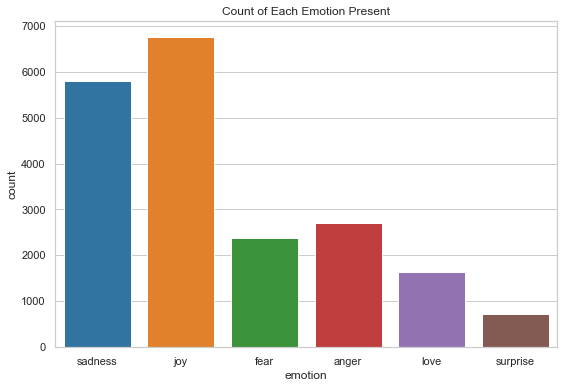

In [697]:
# find the count of each emotion represented.
plt.figure(figsize=(9,6))
sns.countplot(x='emotion', data=df).set_title('Count of Each Emotion Present');

In [698]:
print("COUNT OF EACH EMOTION:")
df['emotion'].value_counts()

COUNT OF EACH EMOTION:


joy         6761
sadness     5797
anger       2709
fear        2373
love        1641
surprise     719
Name: emotion, dtype: int64

From the count plot we can see that this is an imbalanced classification problem.

### 2.2 Sentence Length 
<a class="anchor" id="SL"></a>

/Users/Ayliah/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


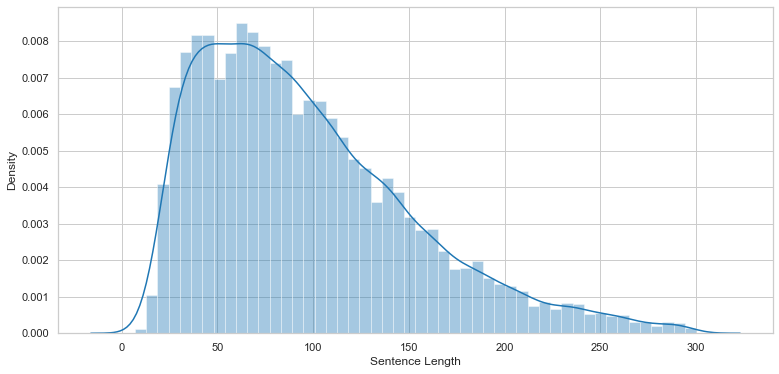

In [699]:
# find distribution of sentence lengths in the data
sentence_length = df['sentence'].str.len()
plt.figure(figsize=(12.8,6))
sns.distplot(sentence_length, kde=True, color='#1f77b4')
plt.xlabel('Sentence Length');

most sentences are ~40-70 characters

In [700]:
# basic stats about sentence length
sentence_length.describe()

count    20000.000000
mean        96.670050
std         55.777923
min          7.000000
25%         53.000000
50%         86.000000
75%        129.000000
max        300.000000
Name: sentence, dtype: float64

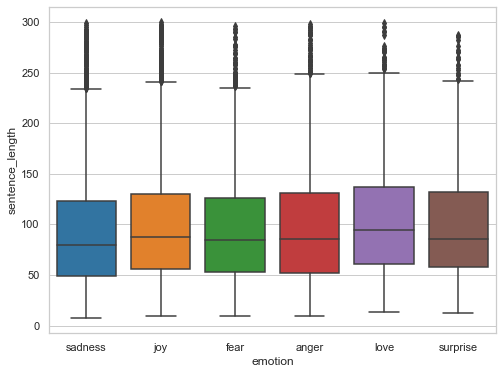

In [701]:
# box plot of sentence length distribution for each emotion
df['sentence_length'] = sentence_length

plt.figure(figsize=(8,6))
sns.boxplot(data=df, x='emotion', y='sentence_length');

sentences of each emotion are generally the same length, so that does not need to be taken into acccount for the classification task

In [975]:
# average sentence length for each emotion
avg_sentence = df.melt(id_vars='sentence_length').groupby(df.emotion).mean()
avg_sentence

,sentence_length
emotion,
0.0,92.776264
1.0,98.109008
2.0,95.666667
3.0,97.047988
4.0,103.778793
5.0,100.196106



## 3. Feature Engineering 
<a class="anchor" id="FE"></a>
___

### 3.1 Text Prep & Cleaning 
<a class="anchor" id="TP"></a>

In [703]:
# find the number of unique words in the dataframe
dictionary1 = list(df['sentence'].str.split(' ', expand=True).stack().unique())
print("number of unique words prior to cleaning: ", len(dictionary1))

number of unique words prior to cleaning:  17096


In [704]:
# define stop words
stop_words = stopwords.words('english')
stop_words.extend(['im','ive','https','href'])

In [705]:
# method adapted from: https://towardsdatascience.com/detecting-bad-customer-reviews-with-nlp-d8b36134dc7e

# part-of-speech tagging for more accurate lemmitisation
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.VERB
    

def clean_text(text):
    # lower text
    text = text.lower()
    # tokenise text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    text = [x for x in text if x not in stop_words]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatise text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # there are still some errors after lemmatising 'feeling' so do it again
    text = [WordNetLemmatizer().lemmatize(t, pos='v') for t in text]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

# clean text data
df["sentence"] = df["sentence"].apply(lambda x: clean_text(x))

### 3.2 Encoding 
<a class="anchor" id="E"></a>

In [706]:
# replace categories with integer value
emotion_dict = {'sadness':0, 'joy':1, 'fear':2, 'anger':3, 'love':4, 'surprise':5}
df['emotion'] = df['emotion'].map(emotion_dict)

### 3.3 Train-Test Split 
<a class="anchor" id="TTS"></a>

In [707]:
# split the data into a train and test set
X_train, X_test, y_train, y_test = train_test_split(df['sentence'], 
                                                    df['emotion'], 
                                                    test_size=0.2,
                                                    stratify= df['emotion'],
                                                    random_state=0)

### 3.4 Text Representation 
<a class="anchor" id="TR"></a>

In [708]:
""" 
term frequency–inverse document frequency reflects how important a word is to a 
document in a collection or corpus

method adapted from: https://github.com/miguelfzafra/Latest-News-Classifier/blob/master/0.%20Latest%20News%20Classifier/04.%20Model%20Training/07.%20MT%20-%20SVM.ipynb
"""

# TF-IDF parameters
ngram_range = (1,2) 
min_df = 1
max_df = 1.0
max_features = 2000

In [709]:
# create TF-IDF vectoriser
tfidf = TfidfVectorizer(ngram_range=ngram_range,
                        lowercase=False,
                        max_df=max_df,
                        min_df=min_df,
                        max_features=max_features,
                        norm='l2',
                        sublinear_tf=True)
                        
#vectorise train and test sets
features_train = tfidf.fit_transform(X_train)
labels_train = y_train
print(features_train.shape)

features_test = tfidf.transform(X_test)
labels_test = y_test
print(features_test.shape)

(16000, 2000)
(4000, 2000)


In [710]:
# Find the most prevalent words in each emotion category
for emotion, emotion_id in sorted(emotion_dict.items()):
    features_chi2 = chi2(features_train, labels_train == emotion_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("-- '{}' category:".format(emotion))
    print("  . Most correlated words:\n. {}".format('\n. '.join(unigrams[-10:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-2:])))
    print("")

-- 'anger' category:
  . Most correlated words:
. piss
. dangerous
. insult
. dissatisfy
. violent
. cranky
. bitchy
. irritable
. resentful
. greedy
  . Most correlated bigrams:
. feel greedy
. feel resentful

-- 'fear' category:
  . Most correlated words:
. reluctant
. shaky
. unsure
. scar
. anxious
. nervous
. apprehensive
. insecure
. vulnerable
. terrify
  . Most correlated bigrams:
. feel nervous
. feel insecure

-- 'joy' category:
  . Most correlated words:
. festive
. resolve
. successful
. rich
. useful
. divine
. energetic
. confident
. talented
. content
  . Most correlated bigrams:
. feel well
. feel content

-- 'love' category:
  . Most correlated words:
. delicate
. gentle
. tender
. supportive
. fond
. naughty
. loyal
. horny
. nostalgic
. sympathetic
  . Most correlated bigrams:
. feel sympathetic
. feel love

-- 'sadness' category:
  . Most correlated words:
. humiliate
. shitty
. ashamed
. homesick
. dull
. discourage
. miserable
. exhaust
. gloomy
. punish
  . Most 

In [711]:
# see how many words have been removed after cleaning
dictionary = list(df['sentence'].str.split(' ', expand=True).stack().unique())
print("number of unique words: ", len(dictionary))

number of unique words:  12838


## 4. Model Building 
<a class="anchor" id="MB"></a>
___

### 4.1 BASE MODEL 
<a class="anchor" id="BM"></a>
use a logistic regression base model to find the best number of features to use, and to compare model performace to the base

In [714]:
# TF-IDF parameters
ngram_range = (1,2)
min_df = 1
max_df = 1.0
max_features = [100, 300, 500, 800, 1000, 2000, 3000, 5000, 7000, 10000]

for i in max_features:
    tfidf = TfidfVectorizer(ngram_range=ngram_range,
                            lowercase=False,
                            max_df=max_df,
                            min_df=min_df,
                            max_features=i,
                            norm='l2',
                            sublinear_tf=True)
    features_train = tfidf.fit_transform(X_train)
    labels_train = y_train
    features_test = tfidf.transform(X_test)
    labels_test = y_test
    # train logistic regression base model at each max_features
    lr_classifier = LogisticRegression(random_state=0, max_iter=1000)
    lr_classifier.fit(features_train, labels_train)
    print("LR score with {} features:".format(i), lr_classifier.score(features_test, labels_test))

LR score with 100 features: 0.359
LR score with 300 features: 0.44675
LR score with 500 features: 0.61
LR score with 800 features: 0.7925
LR score with 1000 features: 0.82675
LR score with 2000 features: 0.8795
LR score with 3000 features: 0.8775
LR score with 5000 features: 0.87725
LR score with 7000 features: 0.87525
LR score with 10000 features: 0.8735


**3000 features** seems to yield the best results, higher values don't add a significant amount of additional accuracy, but are computationally expensive. Therefore 3000 features will be used. 

In [715]:
# TF-IDF with the desired max_features found above
ngram_range = (1,2)
min_df = 1
max_df = 1.0
max_features = 2000

tfidf = TfidfVectorizer(ngram_range=ngram_range,
                        lowercase=False,
                        max_df=max_df,
                        min_df=min_df,
                        max_features=max_features,
                        norm='l2',
                        sublinear_tf=True)
                        
features_train = tfidf.fit_transform(X_train)
labels_train = y_train

features_test = tfidf.transform(X_test)
labels_test = y_test

**EXPORT FILES FOR LATER**

In [983]:
# df
with open('Pickles/df.pickle', 'wb') as output:
    pickle.dump(df, output)
    
# features_train
with open('Pickles/features_train.pickle', 'wb') as output:
    pickle.dump(features_train, output)

# labels_train
with open('Pickles/labels_train.pickle', 'wb') as output:
    pickle.dump(labels_train, output)

# features_test
with open('Pickles/features_test.pickle', 'wb') as output:
    pickle.dump(features_test, output)

# labels_test
with open('Pickles/labels_test.pickle', 'wb') as output:
    pickle.dump(labels_test, output)
    
# TF-IDF object
with open('Pickles/tfidf.pickle', 'wb') as output:
    pickle.dump(tfidf, output)

___
### **4.2 SUPPORT VECTOR MACHINE** 
<a class="anchor" id="SVM"></a>

#### 4.2.1 Build the Model 
<a class="anchor" id="MB-SVM"></a>
**BASE SVM**

In [716]:
#Create the SVM model
svc_base = OneVsRestClassifier(SVC(random_state = 0))

#### 4.2.2 Train & Evaluate 
<a class="anchor" id="TE-SVM"></a>

In [717]:
#Fit the model for the data
svc_base.fit(features_train, labels_train)

#Make the prediction
y_pred_base = svc_base.predict(features_test)

In [718]:
print('The accuracy of the base SVM is: ', svc_base.score(features_test, labels_test))

The accuracy of the base SVM is:  0.879


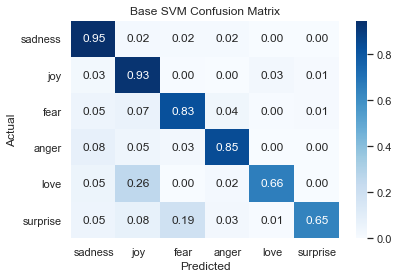

In [976]:
# create confusion matrix
cm = confusion_matrix(labels_test, y_pred_base)

# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# plot
fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(cmn, 
            annot=True, 
            fmt='.2f', 
            xticklabels=emotion_dict, 
            yticklabels=emotion_dict, 
            cmap='Blues')
plt.title('Base SVM Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [720]:
accuracies = cross_val_score(estimator = svc_base, X = features_train, y = labels_train, cv = 3);
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))

Accuracy: 87.91 %


#### 4.2.2 Hyperparameter Optimisation 
<a class="anchor" id="HO-SVM"></a>

SVC hyperparameters to be tuned:
* C, Regularization parameter
* kernel, Specifies the kernel type to be used in the algorithm
* degree, Degree of the polynomial kernel function
* gamma, Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.

https://scikit-learn.org/stable/modules/grid_search.html

First we will use RandomSearchCV since the run time is significantly lower than GridSearchCV. Once there is a general idea of what hyperparameters to use GridSearchCV will be used

In [419]:
# find out the hyperparameters currently in use
svc_base.get_params()

{'estimator__C': 1.0,
 'estimator__break_ties': False,
 'estimator__cache_size': 200,
 'estimator__class_weight': None,
 'estimator__coef0': 0.0,
 'estimator__decision_function_shape': 'ovr',
 'estimator__degree': 3,
 'estimator__gamma': 'scale',
 'estimator__kernel': 'rbf',
 'estimator__max_iter': -1,
 'estimator__probability': False,
 'estimator__random_state': 0,
 'estimator__shrinking': True,
 'estimator__tol': 0.001,
 'estimator__verbose': False,
 'estimator': SVC(random_state=0),
 'n_jobs': None}

**RandomSearchCV:**

In [721]:
## DEFINE THE GRID ###########################################

# C
C = np.linspace(1,100, 30)

# gamma
gamma = [0.001,0.01, 0.1, 1]

# degree
degree = [1, 2, 3, 4, 5]

# kernel
kernel = ['linear', 'rbf', 'poly']

# probability
probability = [True, False]

In [722]:
# SVC random grid
random_grid = {'C': C,
              'kernel': kernel,
              'gamma': gamma,
              'degree': degree,
              'probability': probability
             }

# OneVsRest SVC Random Grid
ovrrandom_grid = {'estimator__C': C,
              'estimator__kernel': kernel,
              'estimator__gamma': gamma,
              'estimator__degree': degree,
              'estimator__probability': probability
             }

In [723]:
## RANDOM SEARCH ###########################################

# First create the base model to tune
#svc = SVC(random_state=0)
svc = OneVsRestClassifier(SVC(random_state=0))

# Define the random search
n_iter_search = 30
random_search = RandomizedSearchCV(estimator=svc,
                                   param_distributions=ovrrandom_grid,
                                   n_iter=n_iter_search,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=3, 
                                   random_state=0, 
                                   n_jobs=-1,
                                   refit=True)

# Fit the random search model
random_search.fit(features_train, labels_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


RandomizedSearchCV(cv=3,
                   estimator=OneVsRestClassifier(estimator=SVC(random_state=0)),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'estimator__C': array([  1.        ,   4.4137931 ,   7.82758621,  11.24137931,
        14.65517241,  18.06896552,  21.48275862,  24.89655172,
        28.31034483,  31.72413793,  35.13793103,  38.55172414,
        41.96551724,  45.37931034,  48.79310345,  52.20689655,
        55.62068966,  59.03448276,  62.44827586,  65.86206897,
        69.27586207,  72.68965517,  76.10344828,  79.51724138,
        82.93103448,  86.34482759,  89.75862069,  93.17241379,
        96.5862069 , 100.        ]),
                                        'estimator__degree': [1, 2, 3, 4, 5],
                                        'estimator__gamma': [0.001, 0.01, 0.1,
                                                             1],
                                        'estimator__kernel': ['linear', 'rbf',
                  

In [724]:
print("")
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)


The best hyperparameters from Random Search are:
{'estimator__probability': True, 'estimator__kernel': 'rbf', 'estimator__gamma': 0.01, 'estimator__degree': 4, 'estimator__C': 59.03448275862069}

The mean accuracy of a model with these hyperparameters is:
0.8830000928301364



**GridSearchCV:**

now that we have a general idea of where to look we can narrow it down with grid search

In [725]:
## DEFINE THE GRID ########################################


#C = np.linspace(45,65, 10)
#gamma = [0.001,0.01, 0.1]
#degree = [4,5,6,7]
#probability = [True, False]
#kernel = ['rbf']


C = np.linspace(45,65, 10)
degree = [3, 4, 5]
gamma = [0.001, 0.01, 0.1]
probability = [True, False]

#param_grid = {'estimator__C': C,
#              'estimator__kernel': kernel,
#              'estimator__gamma': gamma,
#              'estimator__degree': degree,
#              'estimator__probability': probability
#             }


param_grid = [
  {'estimator__C': C, 'estimator__kernel':['linear'], 'estimator__probability':probability},
  {'estimator__C': C, 'estimator__kernel':['poly'], 'estimator__gamma':gamma,'estimator__degree':degree, 'estimator__probability':probability},
  {'estimator__C': C, 'estimator__kernel':['rbf'], 'estimator__gamma':gamma, 'estimator__probability':probability}
]


## GRID SEARCH ###########################################

# First create the base model to tune
svc = OneVsRestClassifier(SVC(random_state=0))

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .20, random_state = 0)

# Define the grid search
grid_search = GridSearchCV(estimator=svc,
                                   param_grid=param_grid,
                                   scoring='accuracy',
                                   cv=cv_sets, 
                                   verbose=3,  
                                   n_jobs=-1,
                                   refit=True)

# Fit the random search model
grid_search.fit(features_train, labels_train)

Fitting 3 folds for each of 260 candidates, totalling 780 fits


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=0, test_size=0.2, train_size=None),
             estimator=OneVsRestClassifier(estimator=SVC(random_state=0)),
             n_jobs=-1,
             param_grid=[{'estimator__C': array([45.        , 47.22222222, 49.44444444, 51.66666667, 53.88888889,
       56.11111111, 58.33333333, 60.55555556, 62.77777778, 65.        ]),
                          'estimator__kernel': ['linear'],
                          'estimator__probabili...
                          'estimator__gamma': [0.001, 0.01, 0.1],
                          'estimator__kernel': ['poly'],
                          'estimator__probability': [True, False]},
                         {'estimator__C': array([45.        , 47.22222222, 49.44444444, 51.66666667, 53.88888889,
       56.11111111, 58.33333333, 60.55555556, 62.77777778, 65.        ]),
                          'estimator__gamma': [0.001, 0.01, 0.1],
                          'estimator__kernel': ['rbf'],
            

In [731]:
print("")
print("The best hyperparameters from Random Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)


The best hyperparameters from Random Search are:
{'estimator__C': 53.888888888888886, 'estimator__gamma': 0.01, 'estimator__kernel': 'rbf', 'estimator__probability': True}

The mean accuracy of a model with these hyperparameters is:
0.8872916666666667


In [732]:
final_svc = grid_search.best_estimator_
final_svc

OneVsRestClassifier(estimator=SVC(C=53.888888888888886, gamma=0.01,
                                  probability=True, random_state=0))

**GRID SEARCH RESULTS & EXPORT**

In [728]:
SVM_gs_results = pd.DataFrame.from_dict(grid_search.cv_results_)
SVM_gs_results.to_excel("SVM GS Results.xlsx")  

#### 4.2.3 Fit & Performance 
<a class="anchor" id="FP-SVM"></a>

In [1001]:
final_svc = OneVsRestClassifier(SVC(C=50, gamma=0.01,
                                  probability=True, random_state=0))

In [1006]:
# fit the final SVM Model and find training time

t = time.time()
final_svc.fit(features_train, labels_train)
elapsed = time.time() - t

print("Training time: ", elapsed)

Training time:  247.88838481903076


In [1003]:
# Export the final trained SVM model
with open('Models/final_svc.pickle', 'wb') as output:
    pickle.dump(final_svc, output)

**Training Accuracy**

In [512]:
# Training accuracy
svm_train_ac = accuracy_score(labels_train, final_svc.predict(features_train))
print("The training accuracy is: ", svm_train_ac)

The training accuracy is:  0.9284375


**Test Accuracy**

In [1011]:
# Make predictions and time the process
t = time.time()
final_svc_pred = final_svc.predict(features_test)
elapsed = time.time() - t

print("Prediction time: ", elapsed)

Prediction time:  7.378368139266968


In [488]:
# Test accuracy
svm_test_ac =  accuracy_score(labels_test, final_svc_pred)
print("The test accuracy is: ", svm_test_ac)

The test accuracy is:  0.8825


In [918]:
# cross validated accuracy
print('The cross validated accuracy is: ', cross_val_score(final_svc, features_train, labels_train, cv=3))

The cross validated accuracy is:  [0.88226472 0.88430527 0.88149259]


**Classification Report**

In [455]:
# Classification report
print("Classification report")
print(classification_report(labels_test,final_svc_pred, target_names=emotion_dict))

Classification report
              precision    recall  f1-score   support

     sadness       0.90      0.94      0.92      1159
         joy       0.88      0.92      0.90      1352
        fear       0.85      0.86      0.85       475
       anger       0.90      0.85      0.88       542
        love       0.84      0.70      0.76       328
    surprise       0.81      0.67      0.73       144

    accuracy                           0.88      4000
   macro avg       0.86      0.82      0.84      4000
weighted avg       0.88      0.88      0.88      4000



**Confusion Matrix**

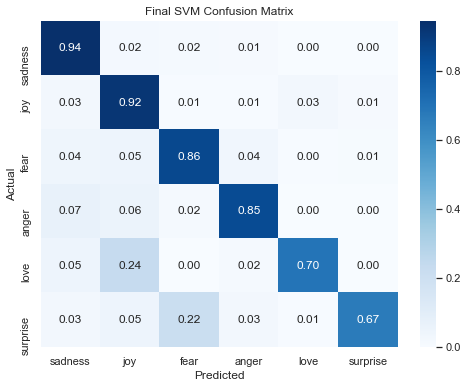

In [456]:
# create confusion matrix
cm_svc_final = confusion_matrix(labels_test, final_svc_pred)

# Normalise
cmn_svc_final = cm_svc_final.astype('float') / cm_svc_final.sum(axis=1)[:, np.newaxis]

# plot
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cmn_svc_final, 
            annot=True, 
            fmt='.2f', 
            xticklabels=emotion_dict, 
            yticklabels=emotion_dict, 
            cmap='Blues')
plt.title('Final SVM Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [457]:
accuracy_score(labels_test, svc_base.predict(features_test))

0.879

In [458]:
accuracy_score(labels_test, final_svc.predict(features_test))

0.8825

___
### **4.3 MULTI-LAYER PERCEPTRON** 
<a class="anchor" id="MLP"></a>

**PREP**

convert tidf matrix into pytorch float type tensor for MLP

In [990]:
x_train = torch.tensor(scipy.sparse.csr_matrix.todense(features_train)).float()
x_test = torch.tensor(scipy.sparse.csr_matrix.todense(features_test)).float()

Convert labels into pytorch tensor

In [991]:
y_train = torch.tensor(labels_train.values)
y_test = torch.tensor(labels_test.values)

Export the train and test sets:

In [992]:
# x_train
with open('Pickles/x_train.pickle', 'wb') as output:
    pickle.dump(x_train, output)

# y_train
with open('Pickles/y_train.pickle', 'wb') as output:
    pickle.dump(y_train, output)

# x_test
with open('Pickles/x_test.pickle', 'wb') as output:
    pickle.dump(x_test, output)

# y_test
with open('Pickles/y_test.pickle', 'wb') as output:
    pickle.dump(y_test, output)

#### 4.3.1 Build the Model 
<a class="anchor" id="MB-MLP"></a>
**BASE MLP:**
For multiclass classification, the model needs one node for each class in the output layer and use the softmax activation function.

In [744]:
# Network parameters
hidden_size = 100               # 1st layer and 2nd layer number of features
input_size = x_train.shape[1]   # Words in vocab
num_classes = 6                 # Categories: sadness, joy, fear, anger, love, surprise
dropout = 0.5
activation = F.relu             # try ReLu, SeLu, RReLU

In [745]:
class MLP(nn.Module):
     def __init__(
         self, 
         input_size = input_size, 
         hidden_size = hidden_size, 
         output_size = num_classes, 
         dropout = dropout,
         activation = activation
     ):
            
        super(MLP, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.activation = activation
        
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        #self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, num_classes)
 
     def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.activation(self.fc2(x))
        x = self.dropout(x)
        #x = self.activation(self.fc3(x))
        x = F.softmax(self.output(x), dim=-1)

        return x

#### 4.3.2 Train & Evaluate <a class="anchor" id="TE-MLP"></a>

In [908]:
"""
DEFAULT TRAINING PARAMETERS:
    epochs: 10
    learning rate: 0.01
    batch size: 128
    optimiser: NLLLoss
    criterion: SGD
"""

#optimizer = optim.Adam
criterion = nn.CrossEntropyLoss

# Callbacks
balanced_accuracy = EpochScoring(scoring='balanced_accuracy', lower_is_better=False)
accuracy = EpochScoring(scoring='accuracy', lower_is_better=False)
early_stopping = EarlyStopping(monitor='valid_loss', patience=10, lower_is_better=True)
checkpoint = Checkpoint(monitor=['train_loss', 'valid_loss'])

Don't change hyperparameters from default so we can experiment with how many layers to have and where to apply dropout

In [342]:
torch.manual_seed(0)

net = NeuralNetClassifier(
    MLP,
    max_epochs = 10,
    optimizer = optimizer,
    criterion = criterion,
    lr = 0.01,
    iterator_train__shuffle = True, 
    callbacks = [balanced_accuracy, accuracy, early_stopping]
)

net.fit(x_train,y_train);

  epoch    accuracy    balanced_accuracy    train_loss    valid_acc    valid_loss     dur
-------  ----------  -------------------  ------------  -----------  ------------  ------
      1      0.7163               0.4790        1.5047       0.7163        1.3358  1.6137
      2      0.7963               0.5807        1.2937       0.7963        1.2427  1.1890
      3      0.8009               0.5897        1.2363       0.8009        1.2365  1.3363
      4      0.8447               0.6727        1.2143       0.8447        1.1977  1.1727
      5      0.8506               0.6850        1.1912       0.8506        1.1901  1.4265
      6      0.8488               0.6958        1.1805       0.8488        1.1925  0.9765
      7      0.8472               0.7015        1.1697       0.8472        1.1942  0.9052
      8      0.8550               0.7035        1.1664       0.8550        1.1879  0.9139
      9      0.8488               0.6956        1.1595       0.8488        1.1930  0.9289
     10   

**NOTES:** from simple modification of the model, it looks like 3 layers works best. Drop out was added to increase performance on the test set

#### 4.3.3 Hyperparameter Optimisation 
<a class="anchor" id="HO-MLP"></a>

In [750]:
# redefine the model with undefined hyperparameters for use with GridSearchCV
net = NeuralNetClassifier(
    MLP,
    criterion = criterion,
    iterator_train__shuffle = True, 
    callbacks = [early_stopping]
)

**RANDOM GRID SEARCH**

In [751]:
net.set_params(verbose=0)
params = {
    'lr': [0.0001,0.001, 0.01],
    'batch_size':[128,256,512],
    'optimizer':[optim.Adam, optim.SGD],
    'max_epochs': [400], # figure out the best number of epochs later with early stopping
    'module__hidden_size': [50,100,200],
    'module__dropout': [0.1, 0.5],
    'module__activation':[F.relu, F.selu, F.leaky_relu]
}

MLP_rs= RandomizedSearchCV(net, 
                           params, 
                           refit=False, 
                           cv=3, 
                           scoring='accuracy', 
                           verbose=1)

MLP_rs.fit(x_train, y_train);

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [346]:
print("")
print("best score: {:.3f}".format(MLP_rs.best_score_))
print("")
print("best params: {}".format(MLP_rs.best_params_))


best score: 0.861

best params: {'module__hidden_size': 100, 'module__dropout': 0.5, 'max_epochs': 100, 'lr': 0.01, 'batch_size': 512}


In [753]:
print("")
print("best score: {:.3f}".format(MLP_rs.best_score_))
print("")
print("best params: {}".format(MLP_rs.best_params_))


best score: 0.854

best params: {'optimizer': <class 'torch.optim.adam.Adam'>, 'module__hidden_size': 200, 'module__dropout': 0.1, 'module__activation': <function selu at 0x7ff5fd6a8430>, 'max_epochs': 400, 'lr': 0.0001, 'batch_size': 128}


**GRID SEARCH**

In [353]:
net.set_params(verbose=0)
params = {
    'lr': [0.001, 0.01],
    'batch_size':[256,300,350],
    'max_epochs': [500],                    # this will be later determined with early stopping
    'module__hidden_size': [50,100,150],
    'module__dropout': [0.3, 0.4, 0.5]
}

MLP_gs = GridSearchCV(net, 
                      params, 
                      refit=True, 
                      cv=3, 
                      scoring='accuracy', 
                      verbose=1)

MLP_gs.fit(x_train, y_train)

print("")
print("best score: {:.3f}".format(MLP_gs.best_score_))
print("")
print("best params: {}".format(MLP_gs.best_params_))

Fitting 3 folds for each of 18 candidates, totalling 54 fits

best score: 0.859

best params: {'batch_size': 350, 'lr': 0.001, 'max_epochs': 500, 'module__dropout': 0.4, 'module__hidden_size': 100}


**GRID SEARCH RESULTS & EXPORT**

In [729]:
MLP_gs_results = pd.DataFrame.from_dict(MLP_gs.cv_results_)
MLP_gs_results.to_excel("MLP GS Results.xlsx")  

#### 4.3.4 Fit & Performance 
<a class="anchor" id="FP-MLP"></a>

**FINAL FIT**

from grid search it was determined that these parametered yielded the highest accuracy:

In [993]:
# Network parameters
hidden_size = 100              
input_size = x_train.shape[1]   
num_classes = 6                
dropout = 0.5
activation = F.relu

# Hyperparameters
batch_size = 256
lr = 0.001
epochs = 62
optimizer = optim.Adam
criterion = nn.CrossEntropyLoss

In [995]:
# rebuild NN with best parameters
class MLP(nn.Module):
     def __init__(
         self, 
         input_size = input_size, 
         hidden_size = hidden_size, 
         output_size = num_classes, 
         dropout = dropout,
         activation = activation
     ):
            
        super(MLP, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.activation = activation
        
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, num_classes)
 
     def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.activation(self.fc2(x))
        x = self.dropout(x)
        x = F.softmax(self.output(x), dim=-1)

        return x

In [1008]:
torch.manual_seed(0)

final_MLP = NeuralNetClassifier(
    MLP,
    max_epochs = epochs,
    batch_size = batch_size,
    optimizer = optimizer,
    criterion = criterion,
    lr = lr,
    iterator_train__shuffle = True, 
    callbacks = [balanced_accuracy, accuracy, early_stopping]
)


t = time.time()
final_MLP.fit(x_train,y_train);
elapsed = time.time() - t

  epoch    accuracy    balanced_accuracy    train_loss    valid_acc    valid_loss     dur
-------  ----------  -------------------  ------------  -----------  ------------  ------
      1      0.3381               0.1667        1.7483       0.3381        1.6703  0.9524
      2      0.5687               0.2998        1.6322       0.5687        1.5466  0.8633
      3      0.6050               0.3207        1.4643       0.6050        1.4060  0.8850
      4      0.6984               0.4340        1.3790       0.6984        1.3545  0.9059
      5      0.7175               0.4590        1.3319       0.7175        1.3193  0.8503
      6      0.7794               0.5471        1.3020       0.7794        1.2927  0.8065
      7      0.8059               0.5853        1.2610       0.8059        1.2507  0.9929
      8      0.8075               0.5914        1.2266       0.8075        1.2349  0.9361
      9      0.8103               0.5950        1.2123       0.8103        1.2289  1.3308
     10   

In [1009]:
print("Training time: ", elapsed)

Training time:  60.64099192619324


In [999]:
# Export the final MLP
with open('Models/final_mlp.pickle', 'wb') as output:
    pickle.dump(final_MLP, output)

In [1010]:
# make predicitons and time it
t = time.time()
MLP_pred = final_MLP.predict(x_test)
elapsed = time.time() - t

print("Prediction time: ", elapsed)

Prediction time:  0.13302993774414062


**PERFORMANCE**

**Training Accuracy**

In [491]:
# Training accuracy
mlp_train_ac = accuracy_score(y_train, final_MLP.predict(x_train))

print("The training accuracy is: ", mlp_train_ac)

The training accuracy is:  0.956625


**Test Accuracy**

In [492]:
# Test accuracy
mlp_test_ac = accuracy_score(y_test, MLP_pred)
print("The test accuracy is: ", mlp_test_ac)

The test accuracy is:  0.866


In [425]:
# cross validated accuracy
print('The cross validated accuracy is: ', cross_val_score(final_MLP, x_train, y_train, cv=3));

  epoch    accuracy    balanced_accuracy    train_loss    valid_acc    valid_loss     dur
-------  ----------  -------------------  ------------  -----------  ------------  ------
      1      0.3383               0.1667        1.7741       0.3383        1.7381  0.4893
      2      0.3383               0.1667        1.6823       0.3383        1.6441  0.4639
      3      0.5918               0.3138        1.5902       0.5918        1.5024  0.6352
      4      0.6012               0.3192        1.4550       0.6012        1.4211  0.4654
      5      0.6589               0.3871        1.3950       0.6589        1.3847  0.5567
      6      0.6954               0.4332        1.3568       0.6954        1.3509  0.4871
      7      0.7099               0.4523        1.3239       0.7099        1.3278  0.4322
      8      0.7104               0.4546        1.3015       0.7104        1.3166  0.4567
      9      0.7142               0.4586        1.2848       0.7142        1.3040  0.4357
     10   

**Classification Report**

In [462]:
# Classification report
print("Classification report")
print(classification_report(y_test, MLP_pred, target_names=emotion_dict))

Classification report
              precision    recall  f1-score   support

     sadness       0.88      0.93      0.90      1159
         joy       0.88      0.91      0.90      1352
        fear       0.83      0.84      0.84       475
       anger       0.88      0.84      0.86       542
        love       0.78      0.68      0.73       328
    surprise       0.82      0.58      0.68       144

    accuracy                           0.87      4000
   macro avg       0.84      0.80      0.82      4000
weighted avg       0.86      0.87      0.86      4000



**Confusion Matrix**

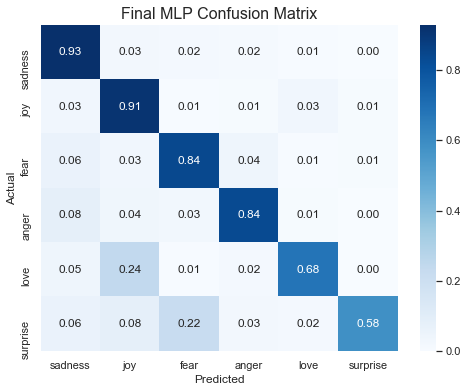

In [429]:
# create confusion matrix
cm_MLP = confusion_matrix(y_test, MLP_pred)

# Normalise
cmn_MLP= cm_MLP.astype('float') / cm_MLP.sum(axis=1)[:, np.newaxis]

# plot
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cmn_MLP, 
            annot=True, 
            fmt='.2f', 
            xticklabels=emotion_dict, 
            yticklabels=emotion_dict, 
            cmap='Blues')
plt.title('Final MLP Confusion Matrix', fontsize= 16)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## 5. Testing & Model Comparison 
<a class="anchor" id="comp"></a>

---

### 5.1 Confusion Matrices
<a class="anchor" id="conf"></a>

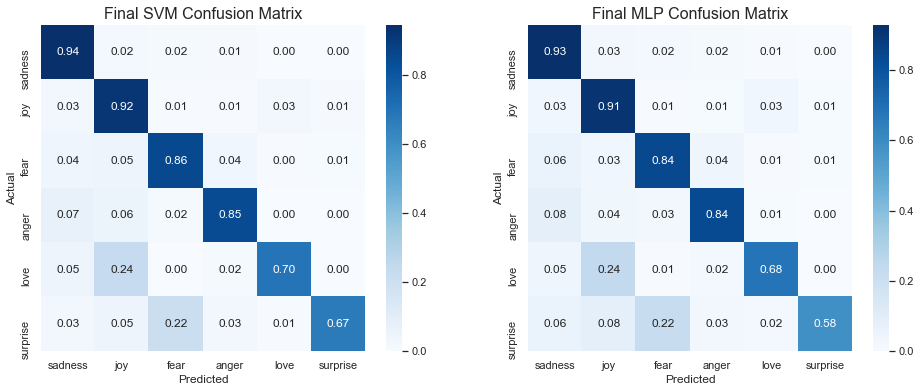

In [478]:
fig, axes =plt.subplots(1,2, sharex=True, figsize=(16,6))

#SVM
sns.heatmap(cmn_svc_final, 
            annot=True, 
            fmt='.2f', 
            xticklabels=emotion_dict, 
            yticklabels=emotion_dict, 
            cmap='Blues', 
            ax = axes[0])
axes[0].set_title('Final SVM Confusion Matrix', fontsize= 16)
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

# MLP
sns.heatmap(cmn_MLP, 
            annot=True, 
            fmt='.2f', 
            xticklabels=emotion_dict, 
            yticklabels=emotion_dict, 
            cmap='Blues', 
            ax = axes[1])
axes[1].set_title('Final MLP Confusion Matrix', fontsize= 16)
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicted');

### 5.2 Accuracy Scores
<a class="anchor" id="acc"></a>

**TRAINING ACCURACY**

In [494]:
# SVM
print("SVM training accuracy: ", svm_train_ac)

# MLP
print("MLP training accuracy: ", mlp_train_ac)

SVM training accuracy:  0.9284375
MLP training accuracy:  0.956625


**TEST ACCURACY**

In [493]:
# SVM
print("SVM test accuracy: ", svm_test_ac)

# MLP
print("MLP test accuracy: ", mlp_test_ac)

SVM test accuracy:  0.8825
MLP test accuracy:  0.866


**CLASSIFICATION REPORTS**

In [505]:
# SVM Classification report
print("--- SVM CLASSIFICATION REPORT ---------------")
print(classification_report(labels_test,final_svc_pred, target_names=emotion_dict))
print("")
print("--- MLP CLASSIFICATION REPORT ---------------")
print(classification_report(y_test, MLP_pred, target_names=emotion_dict))

--- SVM CLASSIFICATION REPORT ---------------
              precision    recall  f1-score   support

     sadness       0.90      0.94      0.92      1159
         joy       0.88      0.92      0.90      1352
        fear       0.85      0.86      0.85       475
       anger       0.90      0.85      0.88       542
        love       0.84      0.70      0.76       328
    surprise       0.81      0.67      0.73       144

    accuracy                           0.88      4000
   macro avg       0.86      0.82      0.84      4000
weighted avg       0.88      0.88      0.88      4000


--- MLP CLASSIFICATION REPORT ---------------
              precision    recall  f1-score   support

     sadness       0.88      0.93      0.90      1159
         joy       0.88      0.91      0.90      1352
        fear       0.83      0.84      0.84       475
       anger       0.88      0.84      0.86       542
        love       0.78      0.68      0.73       328
    surprise       0.82      0.58      

<a class="anchor" id="ROC"></a>
### 5.3 ROC Curves

In [934]:
def plot_roc_curve(y_test, y_pred, model):
    
    n_classes = 6

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(0,6):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(0,6)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(0,6):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(8, 6))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    #colors = itertools.cycle(['aqua', 'coral', 'gold', 'ivory', 'green', 'blue', 'cyan'])
    colors = matplotlib.cm.get_cmap('tab10')
    colors = colors(np.linspace(0, 1, 6))
    for i, color in zip(range(0,6), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                       ''.format(classes[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('{} Receiver Operating Curve'.format(model), fontsize= 16)
    plt.legend(loc="lower right")
    plt.show()

**SVM**

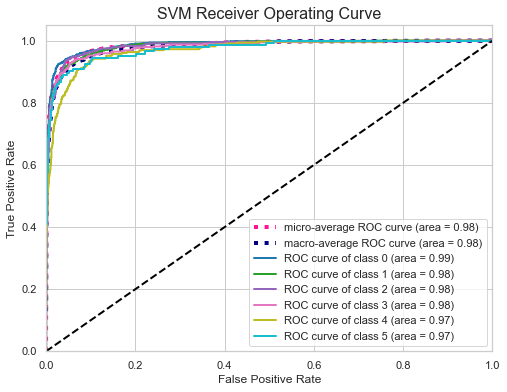

In [933]:
SVM_onehot = label_binarize(labels_test, classes=[0,1,2,3,4,5])
SVM_pred_proba = final_svc.decision_function(features_test)
plot_roc_curve(SVM_onehot, SVM_pred_proba, 'SVM')

**MLP**

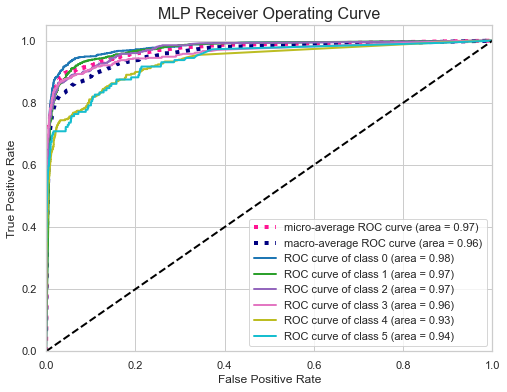

In [884]:
MLP_onehot = label_binarize(y_test, classes=[0,1,2,3,4,5])
MLP_pred_proba = final_MLP.predict_proba(x_test)
plot_roc_curve(MLP_onehot, MLP_pred_proba, 'MLP')